In [ ]:
# Data read-in

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

airports_columns = ['ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz', 'Type', 'Source']
routes_columns = ['Airline', 'Airline_ID', 'Source_Airport', 'Source_Airport_ID', 'Dest_Airport', 'Dest_Airport_ID', 'Codeshare', 'Stops', 'Equipment']


airports = pd.read_csv('airports.dat', names=airports_columns)
routes = pd.read_csv('routes.dat', names=routes_columns)

In [ ]:
!pip install adjustText
from adjustText import adjust_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math

# Method for calculating the metrical-system distance between given location indexes  
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radius of the Earth in kilometers

    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi/2)**2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda/2)**2
    res = R * (2 * math.atan2(math.sqrt(a), math.sqrt(1 - a)))

    return res  # in kilometers

import pandas as pd

# Assuming routes_df and airports_df are your dataframes
routes_with_coordinates = routes.merge(airports[['IATA', 'Latitude', 'Longitude']], left_on='Source_Airport', right_on='IATA', how='left')
routes_with_coordinates = routes_with_coordinates.merge(airports[['IATA', 'Latitude', 'Longitude']], left_on='Dest_Airport', right_on='IATA', how='left', suffixes=('_Source', '_Dest'))

routes_with_coordinates['Distance'] = routes_with_coordinates.apply(lambda row: haversine(row['Latitude_Source'], row['Longitude_Source'], row['Latitude_Dest'], row['Longitude_Dest']), axis=1)


In [ ]:
# Filter out invalid routes
routes = routes[routes['Source_Airport_ID'].apply(lambda x: str(x).isnumeric()) & routes['Dest_Airport_ID'].apply(lambda x: str(x).isnumeric())]
routes['Source_Airport_ID'] = routes['Source_Airport_ID'].astype(int)
routes['Dest_Airport_ID'] = routes['Dest_Airport_ID'].astype(int)


# Create a directed graph
G_filtered = nx.DiGraph()

# Create the position dictionary
pos = {row['ID']: (row['Longitude'], row['Latitude']) for _, row in airports.iterrows()}

# Add nodes and edges to the graph
for index, row in airports.iterrows():
    if row['ID'] in pos:
        G_filtered.add_node(row['ID'], name=row['Name'], city=row['City'], country=row['Country'], 
                            Latitude=row['Latitude'], Longitude=row['Longitude'])


#routes_with_coordinates = routes_with_coordinates.dropna(subset=['Distance'])

for index, row in routes_with_coordinates.iterrows():
    if row['Source_Airport_ID'] in G_filtered.nodes and row['Dest_Airport_ID'] in G_filtered.nodes:
        if G_filtered.has_edge(row['Source_Airport_ID'], row['Dest_Airport_ID']):
            G_filtered[row['Source_Airport_ID']][row['Dest_Airport_ID']]['weight'] += 1
            G_filtered[row['Source_Airport_ID']][row['Dest_Airport_ID']]['distance'] += row['Distance']
            
        else:
            G_filtered.add_edge(row['Source_Airport_ID'], row['Dest_Airport_ID'], weight=1, distance=row['Distance'])
        G_filtered[row['Source_Airport_ID']][row['Dest_Airport_ID']]['airline'] = row['Airline']
        
print(f"Number of nodes: {G_filtered.number_of_nodes()}")
print(f"Number of edges: {G_filtered.number_of_edges()}")
# Calculate average distance
for u, v, data in G_filtered.edges(data=True):
    data['avg_distance'] = data['distance'] / data['weight']


Number of nodes: 7698
Number of edges: 36907


In [ ]:
# calculate degree of each node
degree_dict = dict(G_filtered.degree(G_filtered.nodes()))

# sort nodes by degree in descending order
sorted_degree = sorted(degree_dict.items(), key=lambda item: item[1], reverse=True)

# print top N nodes (airports)
N = 10
for i in range(N):
    airport_id = sorted_degree[i][0]
    airport_name = G_filtered.nodes[airport_id]['name']
    degree = sorted_degree[i][1]
    print(f"Airport {airport_name} (ID: {airport_id}) has a degree of {degree}.")


Airport Frankfurt am Main Airport (ID: 340) has a degree of 477.
Airport Charles de Gaulle International Airport (ID: 1382) has a degree of 470.
Airport Amsterdam Airport Schiphol (ID: 580) has a degree of 463.
Airport Atatürk International Airport (ID: 1701) has a degree of 451.
Airport Hartsfield Jackson Atlanta International Airport (ID: 3682) has a degree of 433.
Airport Chicago O'Hare International Airport (ID: 3830) has a degree of 409.
Airport Beijing Capital International Airport (ID: 3364) has a degree of 408.
Airport Munich Airport (ID: 346) has a degree of 380.
Airport Domodedovo International Airport (ID: 4029) has a degree of 375.
Airport Dallas Fort Worth International Airport (ID: 3670) has a degree of 372.


In [ ]:
from collections import defaultdict

# Counting airlines per airport
airline_counts_per_airport = defaultdict(lambda: defaultdict(int))
airport_id_to_name = {node_id: node_data['name'] for node_id, node_data in G_filtered.nodes(data=True)}


In [ ]:
# We already computed airline counts per airport. Now, let's calculate the most important airport for each airline.
airline_hubs = {}

for airport, airlines in airline_counts_per_airport.items():
    for airline, count in airlines.items():
        if airline not in airline_hubs or count > airline_hubs[airline]['count']:
            airline_hubs[airline] = {
                'hub_airport': airport,
                'count': count
            }

# Convert airline_hubs dictionary items to a list
hub_list = list(airline_hubs.items())

# Sort the list by the number of routes at the hub airport
hub_list.sort(key=lambda x: x[1]['count'], reverse=True)

# Print each airline's hub
for airline, data in hub_list[:80]:
    hub_airport_name = airport_id_to_name[data['hub_airport']]
    print(f"The hub airport for airline {airline} is {hub_airport_name} with {data['count']} routes.")



The hub airport for airline TK is Atatürk International Airport with 197 routes.
The hub airport for airline US is Dallas Fort Worth International Airport with 172 routes.
The hub airport for airline UA is George Bush Intercontinental Houston Airport with 152 routes.
The hub airport for airline SU is Sheremetyevo International Airport with 125 routes.
The hub airport for airline FR is London Stansted Airport with 111 routes.
The hub airport for airline DL is Detroit Metropolitan Wayne County Airport with 98 routes.
The hub airport for airline QR is Hamad International Airport with 94 routes.
The hub airport for airline VY is Barcelona International Airport with 92 routes.
The hub airport for airline KL is Amsterdam Airport Schiphol with 89 routes.
The hub airport for airline LH is Frankfurt am Main Airport with 85 routes.
The hub airport for airline ZH is Beijing Capital International Airport with 81 routes.
The hub airport for airline U2 is London Gatwick Airport with 78 routes.
The h

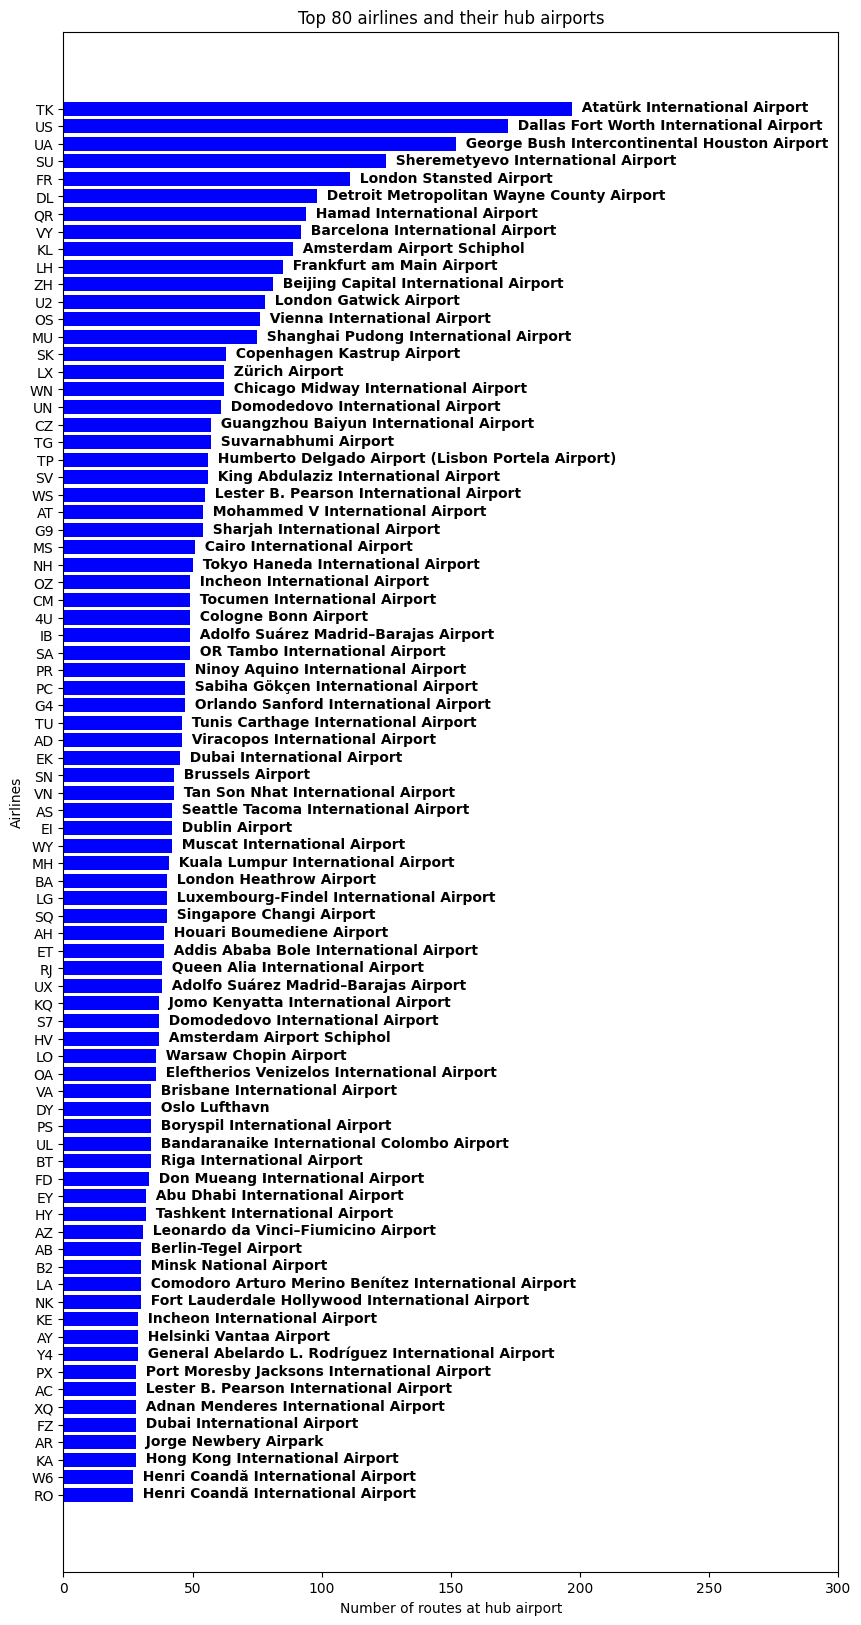

In [ ]:
import matplotlib.pyplot as plt

# Get data for the top 80 airlines
top_airlines = [airline for airline, data in hub_list[:80]]
hub_counts = [data['count'] for airline, data in hub_list[:80]]
hub_airports = [airport_id_to_name[data['hub_airport']] for airline, data in hub_list[:80]]

# Create the figure and the axes
fig, ax = plt.subplots(figsize=(10,20))

# Plot the data
bars = ax.barh(top_airlines, hub_counts, color='blue')

# Annotate the bars with the names of the hub airports
for bar, hub_airport in zip(bars, hub_airports):
    ax.text(bar.get_width(), bar.get_y()+0.35, '  ' + hub_airport,
            va='center', ha='left', color='black', fontweight='bold')

# Invert the y-axis so that the airline with the most routes at their hub airport is on top
ax.invert_yaxis()
ax.set_xlim([0,300])
# Set the labels and the title of the plot
ax.set_xlabel('Number of routes at hub airport')
ax.set_ylabel('Airlines')
ax.set_title('Top 80 airlines and their hub airports')

# Show the plot
plt.show()


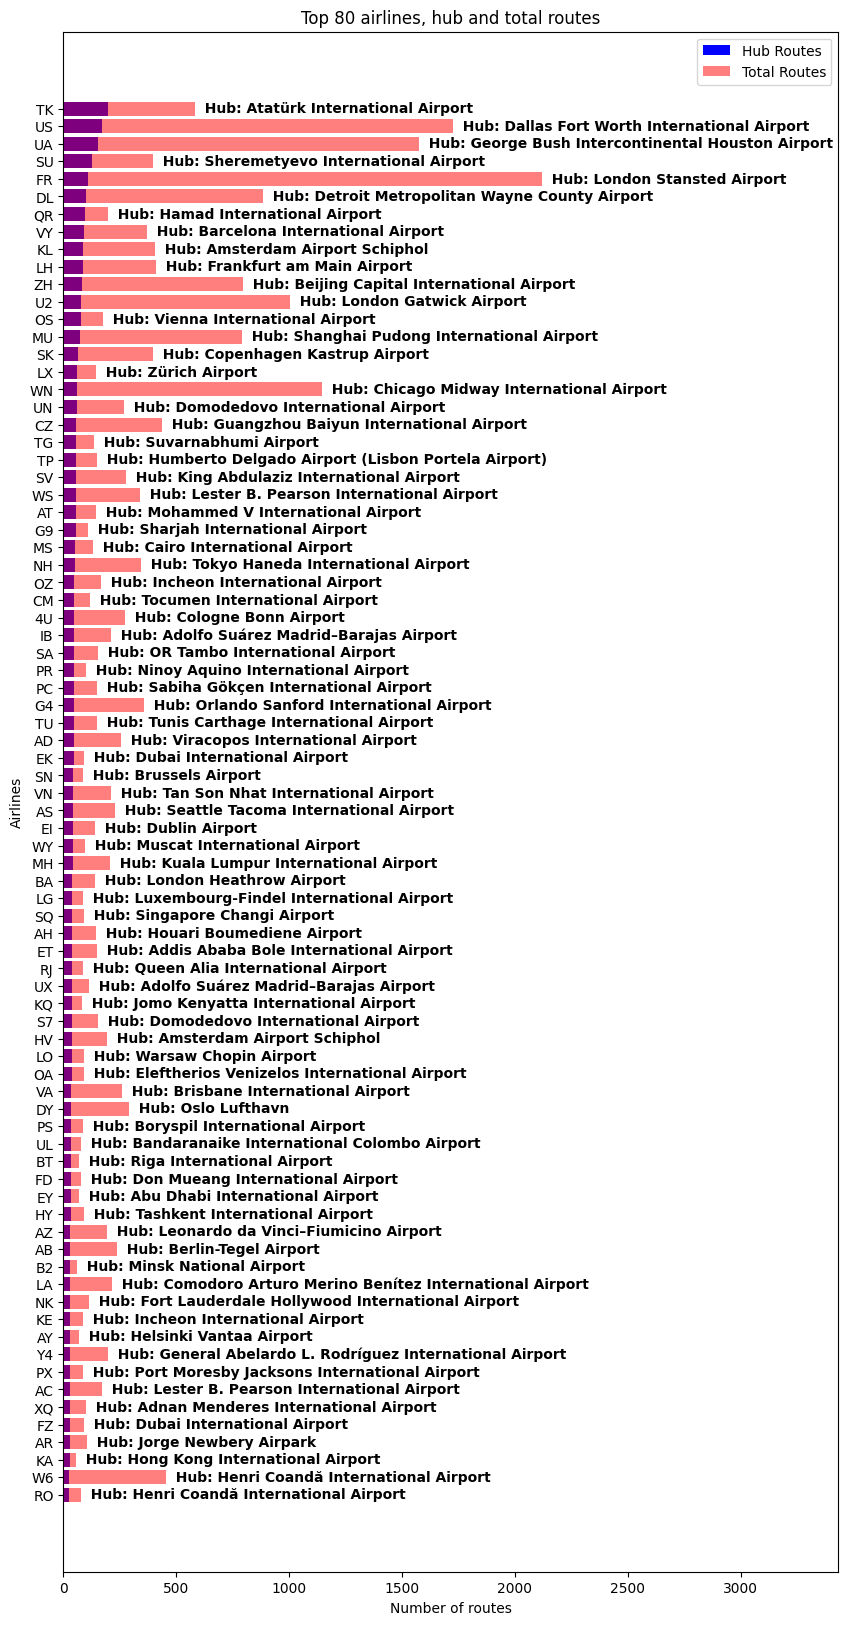

In [ ]:
# Compute total routes for each airline
total_routes_per_airline = {}
for airport, airlines in airline_counts_per_airport.items():
    for airline, count in airlines.items():
        if airline not in total_routes_per_airline:
            total_routes_per_airline[airline] = count
        else:
            total_routes_per_airline[airline] += count

# Add total route counts to airline_hubs dictionary
for airline in airline_hubs:
    airline_hubs[airline]['total_routes'] = total_routes_per_airline[airline]

# Now plot the data
fig, ax = plt.subplots(figsize=(10,20))

# Create the bars for the hub route counts
hub_counts_bars = ax.barh(top_airlines, hub_counts, color='blue')

# Create a new set of bars for the total route counts
total_counts = [airline_hubs[airline]['total_routes'] for airline in top_airlines]
total_counts_bars = ax.barh(top_airlines, total_counts, color='red', alpha=0.5)


# Annotate the bars with the names of the hub airports
for bar, hub_airport in zip(total_counts_bars, hub_airports):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, '  Hub: ' + hub_airport,
            va='center', ha='left', color='black', fontweight='bold')

# Add a legend to explain the colors
ax.legend([hub_counts_bars, total_counts_bars], ['Hub Routes', 'Total Routes'])

# Invert the y-axis and set the labels and the title of the plot
ax.invert_yaxis()
ax.set_xlim([0, max(total_counts)*1.62])
ax.set_xlabel('Number of routes')
ax.set_ylabel('Airlines')
ax.set_title('Top 80 airlines, hub and total routes')

# Show the plot
plt.show()


In [ ]:
# Creating quantitative table with results of Number of Routes at Hub and Total Routes per airport
print("Airline | Hub Airport | Number of Routes at Hub | Total Routes")
print("-"*80)

for i in range(80):
    airline = top_airlines[i]
    hub_airport = hub_airports[i]
    hub_routes = hub_counts[i]
    total_routes = total_counts[i]

    print(f"{airline} | {hub_airport} | {hub_routes} | {total_routes}")


Airline | Hub Airport | Number of Routes at Hub | Total Routes
--------------------------------------------------------------------------------
TK | Atatürk International Airport | 197 | 584
US | Dallas Fort Worth International Airport | 172 | 1725
UA | George Bush Intercontinental Houston Airport | 152 | 1576
SU | Sheremetyevo International Airport | 125 | 398
FR | London Stansted Airport | 111 | 2119
DL | Detroit Metropolitan Wayne County Airport | 98 | 882
QR | Hamad International Airport | 94 | 198
VY | Barcelona International Airport | 92 | 372
KL | Amsterdam Airport Schiphol | 89 | 406
LH | Frankfurt am Main Airport | 85 | 411
ZH | Beijing Capital International Airport | 81 | 797
U2 | London Gatwick Airport | 78 | 1005
OS | Vienna International Airport | 76 | 176
MU | Shanghai Pudong International Airport | 75 | 789
SK | Copenhagen Kastrup Airport | 63 | 395
LX | Zürich Airport | 62 | 145
WN | Chicago Midway International Airport | 62 | 1144
UN | Domodedovo International Airport 

In [ ]:
# Calculate the weight (frequency) of each edge in the graph
route_frequency = [(u, v, data['weight']) for u, v, data in G_filtered.edges(data=True)]

# Sort routes by frequency
route_frequency.sort(key=lambda x: x[2], reverse=True)

# Print top 10 most frequent routes
for u, v, weight in route_frequency[:10]:
    print(f"Route from {G_filtered.nodes[u]['name']} to {G_filtered.nodes[v]['name']} is flown {weight} times.")

Route from Chicago O'Hare International Airport to Hartsfield Jackson Atlanta International Airport is flown 20 times.
Route from Hartsfield Jackson Atlanta International Airport to Chicago O'Hare International Airport is flown 19 times.
Route from Phuket International Airport to Suvarnabhumi Airport is flown 13 times.
Route from Chicago O'Hare International Airport to Louis Armstrong New Orleans International Airport is flown 13 times.
Route from London Heathrow Airport to John F Kennedy International Airport is flown 12 times.
Route from Abu Dhabi International Airport to Muscat International Airport is flown 12 times.
Route from Hong Kong International Airport to Suvarnabhumi Airport is flown 12 times.
Route from Guangzhou Baiyun International Airport to Hangzhou Xiaoshan International Airport is flown 12 times.
Route from Miami International Airport to Hartsfield Jackson Atlanta International Airport is flown 12 times.
Route from Hartsfield Jackson Atlanta International Airport to 

In [ ]:
# Sort the routes in ascending order of average distance.
shortest_routes = sorted(G_filtered.edges(data=True), key=lambda x: x[2]['avg_distance'], reverse=False)

# Display the top 10 shortest routes
for u, v, data in shortest_routes[:10]:
    print(f"Route from {G_filtered.nodes[u]['name']} to {G_filtered.nodes[v]['name']} has an average distance of {data['avg_distance']:.2f} km")


Route from Maya-Maya Airport to Ndjili International Airport has an average distance of 25.95 km
Route from Ndjili International Airport to Maya-Maya Airport has an average distance of 25.95 km
Route from Kirkwall Airport to Stronsay Airport has an average distance of 26.64 km
Route from Kirkwall Airport to Eday Airport has an average distance of 26.98 km
Route from Natashquan Airport to Kegaska Airport has an average distance of 37.27 km
Route from Kirkwall Airport to Sanday Airport has an average distance of 37.54 km
Route from Kirkenes Airport (Høybuktmoen) to Vadsø Airport has an average distance of 37.79 km
Route from Campbell River Airport to Comox Airport has an average distance of 38.35 km
Route from Båtsfjord Airport to Berlevåg Airport has an average distance of 38.58 km
Route from Guernsey Airport to Jersey Airport has an average distance of 38.80 km


In [ ]:
# Find the longest routes
longest_routes = sorted(G_filtered.edges(data=True), key=lambda x: x[2]['avg_distance'], reverse=True)

# Display the top 10 longest routes
for u, v, data in longest_routes[:10]:
    print(f"Route from {G_filtered.nodes[u]['name']} to {G_filtered.nodes[v]['name']} has an average distance of {data['avg_distance']:.2f} km")


Route from OR Tambo International Airport to Hartsfield Jackson Atlanta International Airport has an average distance of 13582.59 km
Route from Hartsfield Jackson Atlanta International Airport to OR Tambo International Airport has an average distance of 13582.59 km
Route from Hong Kong International Airport to John F Kennedy International Airport has an average distance of 12970.38 km
Route from Hong Kong International Airport to Newark Liberty International Airport has an average distance of 12959.91 km
Route from OR Tambo International Airport to John F Kennedy International Airport has an average distance of 12831.33 km
Route from Lester B. Pearson International Airport to Hong Kong International Airport has an average distance of 12548.53 km
Route from Hong Kong International Airport to Lester B. Pearson International Airport has an average distance of 12548.53 km
Route from Chhatrapati Shivaji International Airport to Newark Liberty International Airport has an average distance of

In [ ]:
# Calculating the degree for hubs
airlines_degrees = G_filtered.degree()
sorted_airlines_by_degree = sorted(airlines_degrees, key=lambda x: x[1], reverse=True)
airlines_with_most_routes = sorted_airlines_by_degree[:20]  # Change number as needed

# Convert the airline IDs to IATA code or airport name
airlines_with_most_routes_info = []
for airline_id, degree in airlines_with_most_routes:
    airline_data = G_filtered.nodes[airline_id]
    iata_code = airline_data['country']
    airport_name = airline_data['name']
    airlines_with_most_routes_info.append((iata_code, airport_name, degree))

airlines_with_most_routes_info


[('Germany', 'Frankfurt am Main Airport', 477),
 ('France', 'Charles de Gaulle International Airport', 470),
 ('Netherlands', 'Amsterdam Airport Schiphol', 463),
 ('Turkey', 'Atatürk International Airport', 451),
 ('United States', 'Hartsfield Jackson Atlanta International Airport', 433),
 ('United States', "Chicago O'Hare International Airport", 409),
 ('China', 'Beijing Capital International Airport', 408),
 ('Germany', 'Munich Airport', 380),
 ('Russia', 'Domodedovo International Airport', 375),
 ('United States', 'Dallas Fort Worth International Airport', 372),
 ('United Arab Emirates', 'Dubai International Airport', 364),
 ('United Kingdom', 'London Heathrow Airport', 340),
 ('United States', 'George Bush Intercontinental Houston Airport', 337),
 ('United States', 'Denver International Airport', 335),
 ('United Kingdom', 'London Gatwick Airport', 330),
 ('Spain', 'Barcelona International Airport', 326),
 ('United States', 'John F Kennedy International Airport', 322),
 ('Italy', 'L

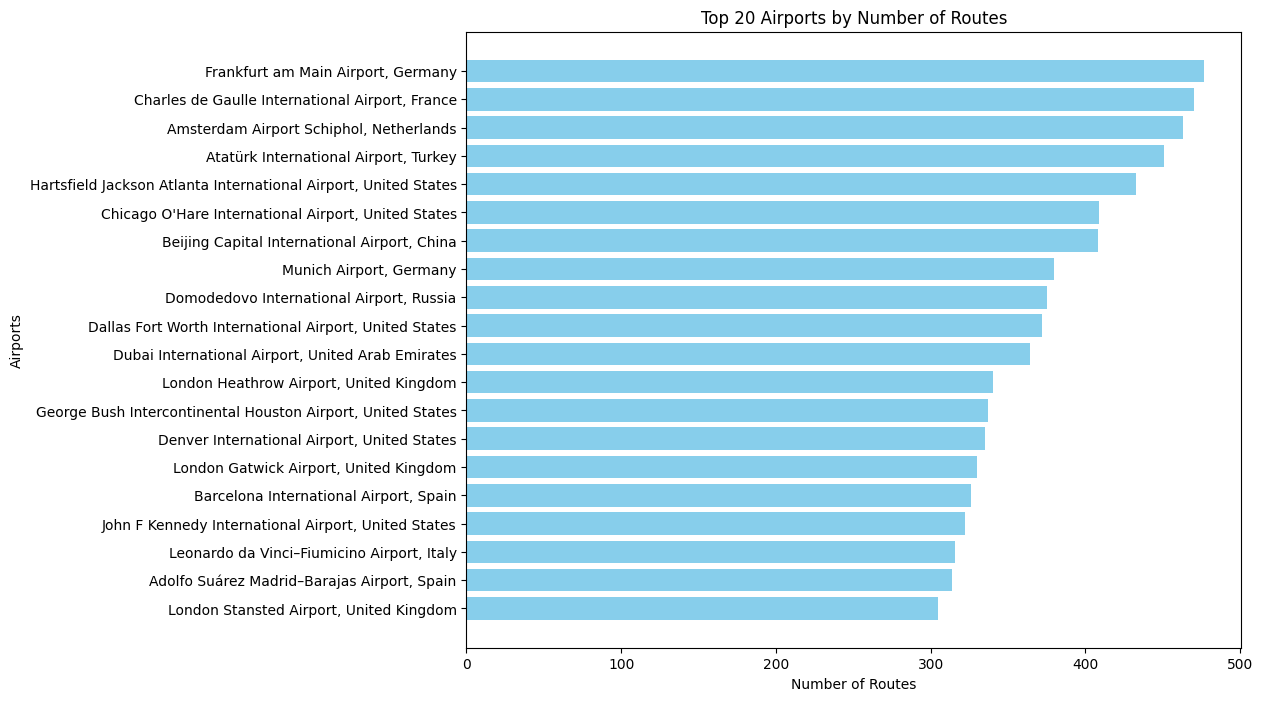

In [ ]:
import matplotlib.pyplot as plt

# Extract the data
countries, airports, degrees = zip(*airlines_with_most_routes_info)

# Create new labels by concatenating country and airport name
labels = [f'{airport}, {country}' for airport, country in zip(airports, countries)]

# Create the plot with Top 20 Airports by Number of Routes
plt.figure(figsize=(10, 8))
plt.barh(labels, degrees, color='skyblue')
plt.gca().invert_yaxis()  # reverse the order of airlines
plt.xlabel('Number of Routes')
plt.ylabel('Airports')
plt.title('Top 20 Airports by Number of Routes')
plt.show()


In [ ]:
# Routes which have more than 0 stops
routes[routes["Stops"]>0]

Airline Airline_ID Source_Airport  Source_Airport_ID Dest_Airport  \
2066       5T       1623            YRT                132          YEK   
7810       AC        330            ABJ                253          BRU   
8272       AC        330            YVR                156          YBL   
17767      CU       1936            FCO               1555          HAV   
25116      FL       1316            HOU               3566          SAT   
25220      FL       1316            MCO               3878          HOU   
25230      FL       1316            MCO               3878          ORF   
49746      SK       4319            ARN                737          GEV   
63567      WN       4547            BOS               3448          MCO   
64042      WN       4547            MCO               3878          BOS   
64045      WN       4547            MCO               3878          CAK   

       Dest_Airport_ID Codeshare  Stops Equipment  
2066                50       NaN      1       ATR  
7810               302       NaN      1       333  
8272                30       NaN      1       BEH  
17767             1909       NaN      1       767  
25116             3621       NaN      1       735  
25220             3566       NaN      1       73W  
25230             3611       NaN      1       717  
49746              715       NaN      1       ATP  
63567             3878       NaN      1       73W  
64042             3448       NaN      1       73W  
64045             4112       NaN      1   73C 73W

In [ ]:
from collections import defaultdict

airline_counts_per_airport = defaultdict(lambda: defaultdict(int))

# Loop over all edges and count airlines per airport
for airport1, airport2, data in G_filtered.edges(data=True):
    airline_counts_per_airport[airport1][data['airline']] += 1


# Initialize an empty dictionary to store dominant airlines and their counts
dominant_airlines_counts_per_airport = {}

# Find the dominant airline and its count for each airport
for airport, airlines in airline_counts_per_airport.items():
    dominant_airline = max(airlines.items(), key=lambda x: x[1])
    total_count = sum(airlines.values())
    dominant_airlines_counts_per_airport[airport] = {
        'dominant_airline': dominant_airline[0],
        'count': dominant_airline[1],
        'proportion': dominant_airline[1] / total_count,
        'total_count': total_count
    }

# Create a dictionary to map airport IDs to names
airport_id_to_name = {node_id: node_data['name'] for node_id, node_data in G_filtered.nodes(data=True)}

# Sort airports by count of dominant airlines in descending order
sorted_airports = sorted(dominant_airlines_counts_per_airport.items(), key=lambda x: x[1]['count'], reverse=True)

# Print the dominant airline, count, and proportion for each airport with the airport name
for airport_id, data in sorted_airports[:15]:
    airport_name = airport_id_to_name[airport_id]
    print(f"Airport: {airport_name}, Dominant Airline: {data['dominant_airline']}, Count: {data['count']}, Proportion: {data['proportion']:.2%}")



Airport: Atatürk International Airport, Dominant Airline: TK, Count: 197, Proportion: 87.95%
Airport: Dallas Fort Worth International Airport, Dominant Airline: US, Count: 172, Proportion: 91.98%
Airport: George Bush Intercontinental Houston Airport, Dominant Airline: UA, Count: 152, Proportion: 89.94%
Airport: Charlotte Douglas International Airport, Dominant Airline: US, Count: 132, Proportion: 93.62%
Airport: Newark Liberty International Airport, Dominant Airline: UA, Count: 126, Proportion: 82.35%
Airport: Sheremetyevo International Airport, Dominant Airline: SU, Count: 125, Proportion: 86.81%
Airport: London Stansted Airport, Dominant Airline: FR, Count: 111, Proportion: 72.55%
Airport: Chicago O'Hare International Airport, Dominant Airline: US, Count: 111, Proportion: 53.88%
Airport: Miami International Airport, Dominant Airline: US, Count: 110, Proportion: 81.48%
Airport: Philadelphia International Airport, Dominant Airline: US, Count: 105, Proportion: 86.07%
Airport: Washington

In [ ]:
# Filter airports with total count greater than 50
filtered_airports = [airport for airport, data in dominant_airlines_counts_per_airport.items() if data['total_count'] > 50]

# Sort filtered airports by proportion in descending order
sorted_filtered_airports = sorted(filtered_airports, key=lambda airport: dominant_airlines_counts_per_airport[airport]['proportion'], reverse=True)

# Print the dominant airline, count, and proportion for each airport
for airport in sorted_filtered_airports[:50]:
    airport_name = airport_id_to_name[airport]
    data = dominant_airlines_counts_per_airport[airport]
    print(f"Airport: {airport_name}, Dominant Airline: {data['dominant_airline']}, Count: {data['count']}, Proportion: {data['proportion']:.2%}")


Airport: Charlotte Douglas International Airport, Dominant Airline: US, Count: 132, Proportion: 93.62%
Airport: Dallas Fort Worth International Airport, Dominant Airline: US, Count: 172, Proportion: 91.98%
Airport: Viracopos International Airport, Dominant Airline: AD, Count: 46, Proportion: 90.20%
Airport: George Bush Intercontinental Houston Airport, Dominant Airline: UA, Count: 152, Proportion: 89.94%
Airport: Brussels South Charleroi Airport, Dominant Airline: FR, Count: 74, Proportion: 89.16%
Airport: Atatürk International Airport, Dominant Airline: TK, Count: 197, Proportion: 87.95%
Airport: Sheremetyevo International Airport, Dominant Airline: SU, Count: 125, Proportion: 86.81%
Airport: Philadelphia International Airport, Dominant Airline: US, Count: 105, Proportion: 86.07%
Airport: Chicago Midway International Airport, Dominant Airline: WN, Count: 62, Proportion: 83.78%
Airport: Newark Liberty International Airport, Dominant Airline: UA, Count: 126, Proportion: 82.35%
Airport: 

<ipython-input-22-ad2be6df3bc8>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = cm.get_cmap('tab20', len(unique_airlines))


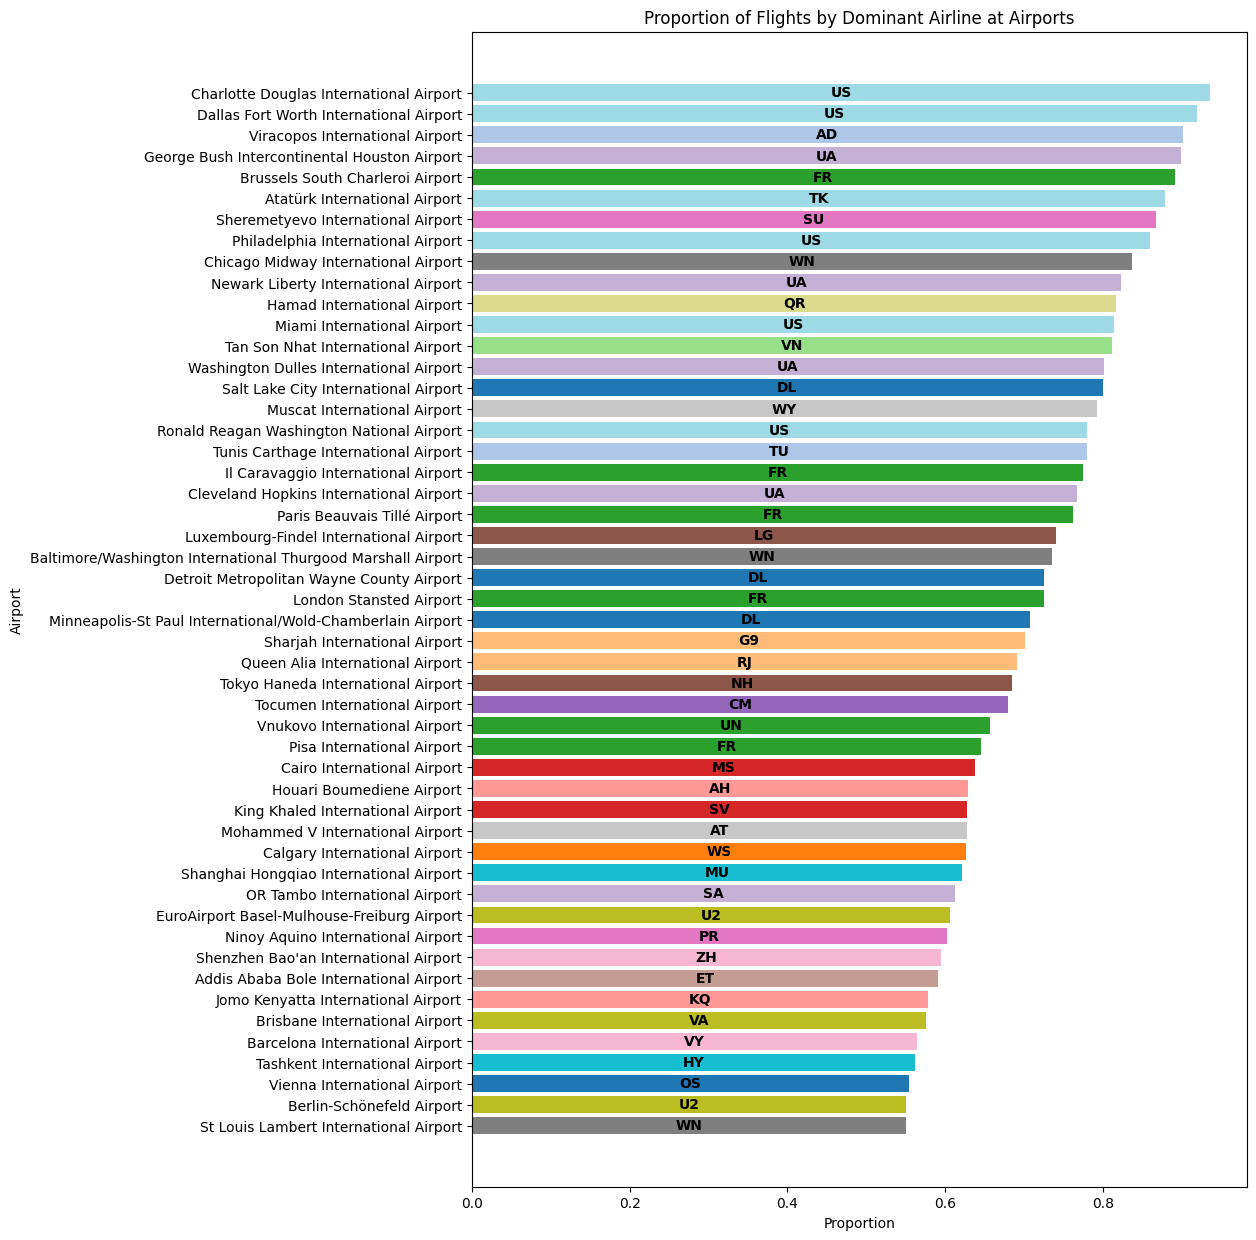

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Retrieve the relevant data for visualization
airport_names = [airport_id_to_name[airport] for airport in sorted_filtered_airports[:50]]
proportions = [dominant_airlines_counts_per_airport[airport]['proportion'] for airport in sorted_filtered_airports[:50]]
dominant_airlines = [dominant_airlines_counts_per_airport[airport]['dominant_airline'] for airport in sorted_filtered_airports[:50]]

# Create a set of unique airlines
unique_airlines = list(set(dominant_airlines))

# Choose a color palette with more variation
color_palette = cm.get_cmap('tab20', len(unique_airlines))

# Create the bar chart
plt.figure(figsize=(10, 15))
bars = plt.barh(airport_names, proportions, color=[color_palette(unique_airlines.index(airline)) for airline in dominant_airlines])

# Set the chart title and labels
plt.title('Proportion of Flights by Dominant Airline at Airports')
plt.xlabel('Proportion')
plt.ylabel('Airport')

# Invert the y-axis to display airports from top to bottom
plt.gca().invert_yaxis()

# Create a legend for dominant airlines
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color_palette(i)) for i in range(len(unique_airlines))]


# Write airline names on the bars
for bar, airport_name in zip(bars, dominant_airlines):
    bar_width = bar.get_width()
    bar_height = bar.get_height()
    plt.text(bar_width / 2, bar.get_y() + bar_height / 2, airport_name, ha='center', va='center', color='black', fontweight='bold')

# Display the chart
plt.show()


Hub airport: Frankfurt am Main Airport (Frankfurt, Germany)


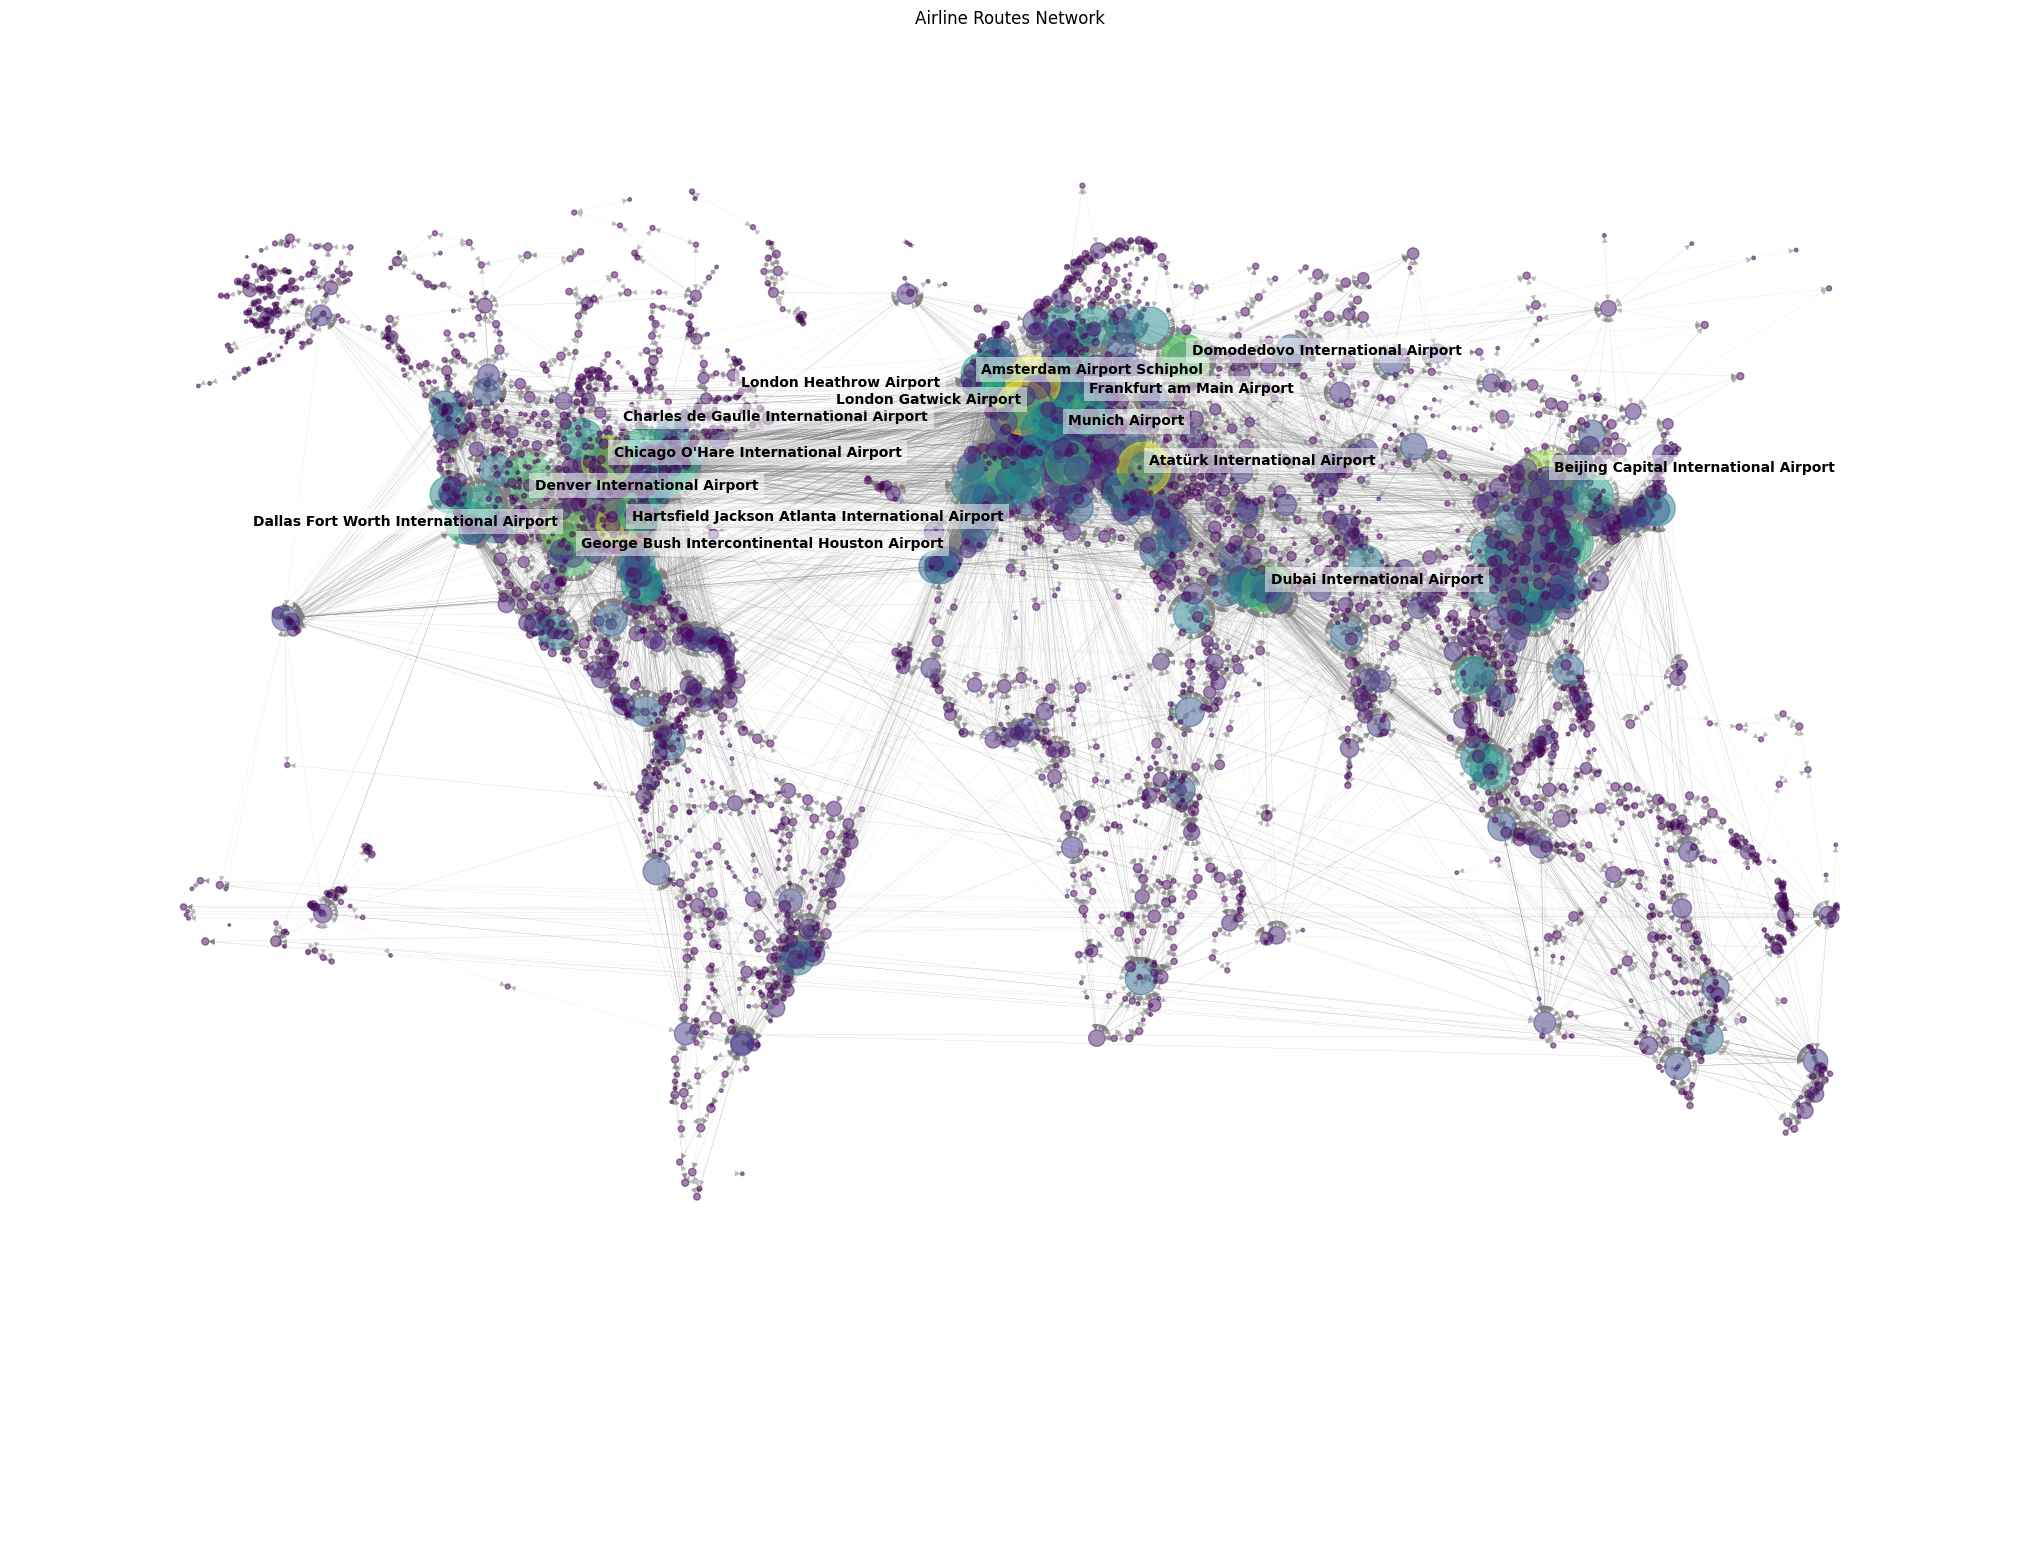

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Finding the hub with the biggest degree
degree_centrality = nx.degree_centrality(G_filtered)
hub_airport = max(degree_centrality, key=degree_centrality.get)
print(f"Hub airport: {G_filtered.nodes[hub_airport]['name']} ({G_filtered.nodes[hub_airport]['city']}, {G_filtered.nodes[hub_airport]['country']})")

# Creating airline routes network

# Get edge weights for visualization
edge_weights = [data['weight'] for (u, v, data) in G_filtered.edges(data=True)]

# Normalize edge weights for better visualization
normalized_weights = [0.8 * (w / max(edge_weights)) for w in edge_weights]

# Customize node sizes based on degree centrality
node_sizes = [25000 * degree_centrality[node] for node in G_filtered.nodes]

# Customize node colors based on degree centrality
node_colors = [degree_centrality[node] for node in G_filtered.nodes]


top_k = 15
top_k_centrality = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:top_k]
top_k_positions = {node: pos[node] for node in top_k_centrality}


# Draw the graph
plt.figure(figsize=(20, 15))
nx.draw(G_filtered, pos,
        node_size=node_sizes,
        node_color=node_colors,
        cmap=plt.cm.viridis,
        edge_color='gray',
        width=normalized_weights,
        with_labels=False,
        alpha=0.5)


# Draw labels for top-k cities
texts = []
for node in top_k_positions:
    x, y = top_k_positions[node]
    label = G_filtered.nodes[node]['name']
    texts.append(plt.text(x, y, label, fontsize=10, weight = "bold", bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')))

adjust_text(texts)
plt.title("Airline Routes Network")
plt.show()



In [ ]:


# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G_filtered)

# Find the node with the highest betweenness centrality
hub_airport = max(betweenness_centrality, key=betweenness_centrality.get)
print(f"Hub airport: {G_filtered.nodes[hub_airport]['name']} ({G_filtered.nodes[hub_airport]['city']}, {G_filtered.nodes[hub_airport]['country']})")

# Customize node sizes based on betweenness centrality
node_sizes = [25000 * betweenness_centrality[node] for node in G_filtered.nodes]

# Customize node colors based on betweenness centrality
node_colors = [betweenness_centrality[node] for node in G_filtered.nodes]

# Find the top-k nodes with the highest betweenness centrality
top_k = 15
top_k_centrality = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:top_k]
top_k_positions = {node: pos[node] for node in top_k_centrality}

# Draw the graph
plt.figure(figsize=(20, 15))
nx.draw(G_filtered, pos,
        node_size=node_sizes,
        node_color=node_colors,
        cmap=plt.cm.viridis,
        edge_color='gray',
        width=normalized_weights,
        with_labels=False,
        alpha=0.5)

# Draw labels for top-k nodes
texts = []
for node in top_k_positions:
    x, y = top_k_positions[node]
    label = G_filtered.nodes[node]['name']
    texts.append(plt.text(x, y, label, fontsize=10, weight="bold", bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')))

adjust_text(texts)
plt.title("Airline Routes Network")
plt.show()



KeyboardInterrupt: ignored

In [ ]:
!pip uninstall community

!pip install python-louvain


Found existing installation: community 1.0.0b1
Uninstalling community-1.0.0b1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/community-1.0.0b1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/community/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.10/dist-packages/community/community_louvain.py
    /usr/local/lib/python3.10/dist-packages/community/community_status.py
Proceed (Y/n)? Y
  Successfully uninstalled community-1.0.0b1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import networkx as nx
from networkx.algorithms import community

G_undirected = G_filtered.to_undirected()

In [ ]:
# Using Louvain's method to depict the airlines' communities

from community import community_louvain
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Compute the best partition
partition = community_louvain.best_partition(G_undirected, weight = "weight", resolution = 1, random_state = 42)

# Create communities mapping
communities = list(set(partition.values()))
community_mapping = {node: community for node, community in partition.items()}


In [ ]:
from collections import Counter
import matplotlib.cm as cm
# Count the nodes in each community
community_counts = Counter(partition.values())
# Create communities mapping only for communities that have more than 10 nodes
large_communities = [comm for comm, count in community_counts.items() if count > 22]

colors = list(cm.tab20.colors)

# Assign a unique color to each large community
community_colors = {comm: colors[i % len(colors)] for i, comm in enumerate(large_communities)}


# Customize node colors based on their community, use gray color for small communities
node_colors = [community_colors.get(partition[node], 'gray') for node in G_undirected.nodes]


In [ ]:
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.74117647

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


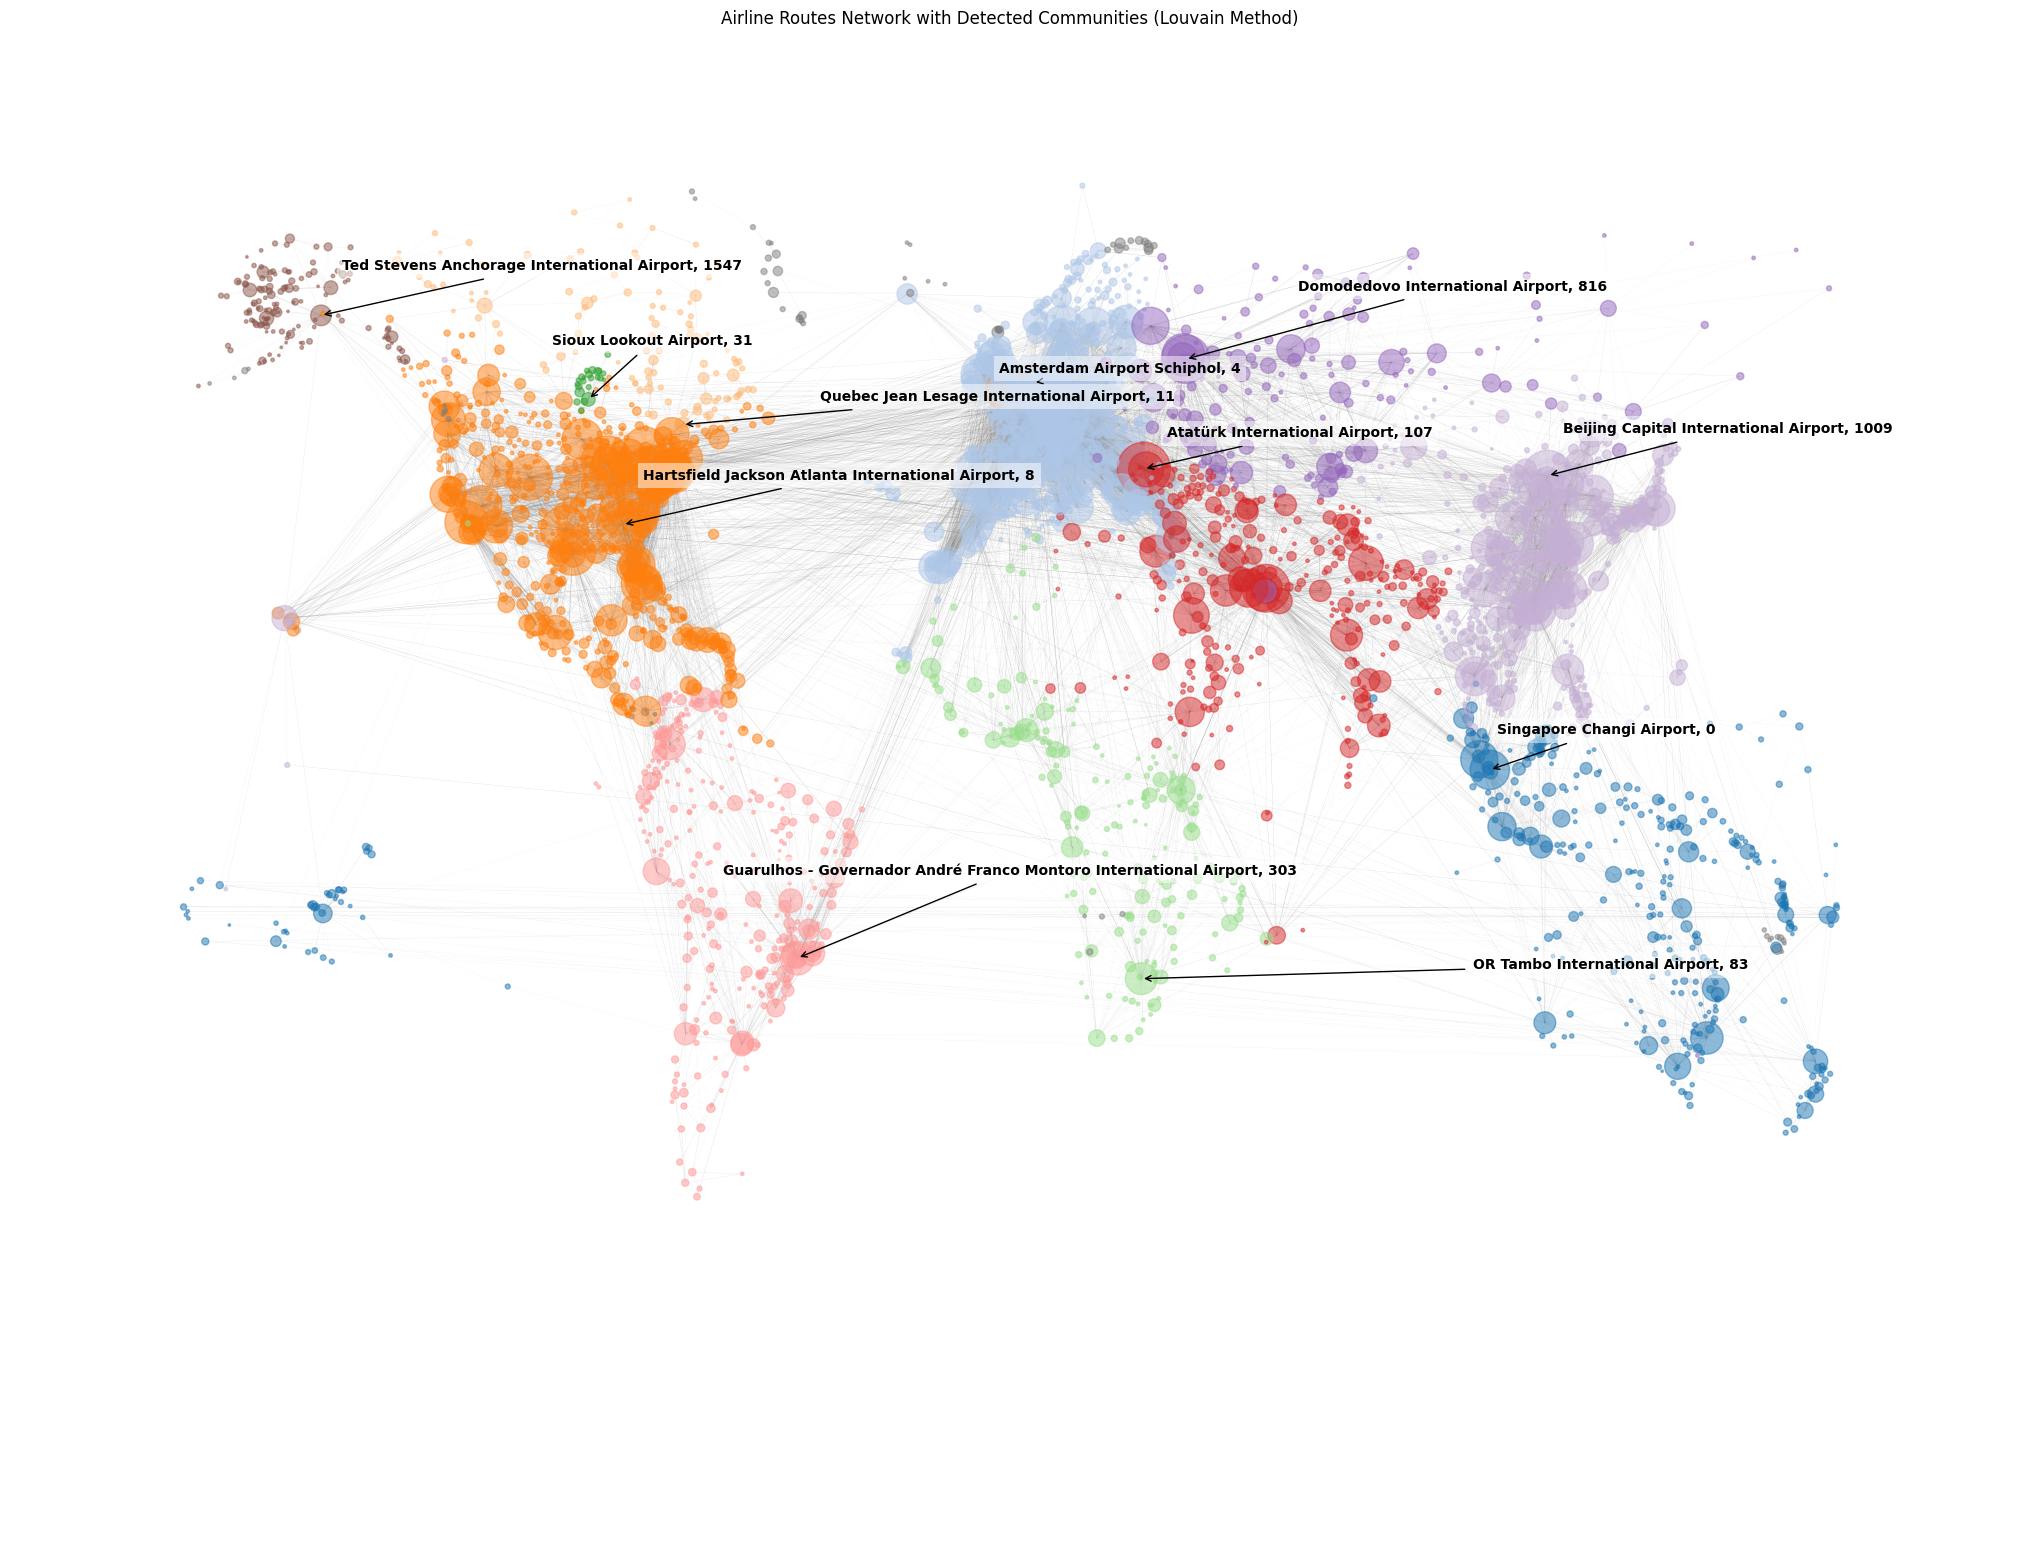

In [ ]:
# Add labels for communities
labels = {}
for comm in large_communities:
    nodes_in_community = [node for node, community in partition.items() if community == comm]
    # Find the node with the highest degree in this community
    highest_degree_node = max(nodes_in_community, key=lambda node: G_undirected.degree[node])
    airport_name = airport_id_to_name[highest_degree_node]
    community_label = f"{airport_name}, {comm}"
    labels[highest_degree_node] = community_label  # use node name and community as the label

plt.figure(figsize=(20, 15))
nx.draw(G_undirected, pos,
        node_size=(node_sizes),
        node_color=node_colors,
        edge_color='gray',
        width=normalized_weights,
        with_labels=False,
        alpha=0.5)

annotations = []
for node in labels:
    x, y = pos[node]
    annotations.append(plt.annotate(labels[node], xy=(x, y), xytext=(x, y),
                                    arrowprops=dict(arrowstyle='->'),
                                    fontsize=10, weight="bold",
                                    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')))

adjust_text(annotations)

plt.title("Airline Routes Network with Detected Communities (Louvain Method)")
plt.show()


In [ ]:
large_communities

[0, 4, 8, 11, 31, 83, 107, 303, 816, 1009, 1547]

In [ ]:
from collections import defaultdict

# Initialize an empty dictionary to store airline counts per community
airline_counts_per_community = defaultdict(lambda: defaultdict(int))

# Loop over all nodes in each community and count airlines
for node, community_idx in partition.items():
    for neighbor, data in G_filtered[node].items():
        if community_idx in large_communities:
            airline_counts_per_community[community_idx][data['airline']] += 1

# Initialize an empty dictionary to store dominant airlines and their counts
dominant_airlines_counts_per_community = {}

# Find the dominant airlines and their counts for each community
for community, airlines in airline_counts_per_community.items():
    dominant_airlines = sorted(airlines.items(), key=lambda x: x[1], reverse=True)[:5] 
    total_count = sum(airlines.values())

    dominant_airlines_counts_per_community[community] = []
    for airline, count in dominant_airlines:
        proportion = count / total_count
        dominant_airlines_counts_per_community[community].append({
            'dominant_airline': airline,
            'count': count,
            'proportion': proportion,
            'total_count': total_count
        })

# Print the dominant airlines, counts, and proportions for each community
for community, data in dominant_airlines_counts_per_community.items():
    print(f"Community: {community}")
    for dominant_airline_data in data:
        print(f"Dominant Airline: {dominant_airline_data['dominant_airline']}, Count: {dominant_airline_data['count']}, Proportion: {dominant_airline_data['proportion']:.2%}")
    print()


Community: 0
Dominant Airline: VA, Count: 237, Proportion: 11.60%
Dominant Airline: MH, Count: 169, Proportion: 8.27%
Dominant Airline: QF, Count: 130, Proportion: 6.36%
Dominant Airline: JT, Count: 126, Proportion: 6.17%
Dominant Airline: NZ, Count: 118, Proportion: 5.78%

Community: 4
Dominant Airline: FR, Count: 2119, Proportion: 17.76%
Dominant Airline: U2, Count: 1004, Proportion: 8.41%
Dominant Airline: W6, Count: 443, Proportion: 3.71%
Dominant Airline: SK, Count: 374, Proportion: 3.13%
Dominant Airline: VY, Count: 363, Proportion: 3.04%

Community: 8
Dominant Airline: US, Count: 1551, Proportion: 18.18%
Dominant Airline: UA, Count: 1315, Proportion: 15.41%
Dominant Airline: WN, Count: 1144, Proportion: 13.41%
Dominant Airline: DL, Count: 841, Proportion: 9.86%
Dominant Airline: G4, Count: 358, Proportion: 4.20%

Community: 11
Dominant Airline: 7F, Count: 54, Proportion: 15.21%
Dominant Airline: 3H, Count: 54, Proportion: 15.21%
Dominant Airline: MO, Count: 43, Proportion: 12.11

In [ ]:
total = sum(sum(inner_dict.values()) for inner_dict in airline_counts_per_community.values())
total

36757

In [ ]:
G_filtered.number_of_edges()

36907

In [ ]:
degree_centrality = nx.degree_centrality(G_undirected)
betweenness_centrality = nx.betweenness_centrality(G_undirected)
eigenvector_centrality = nx.eigenvector_centrality(G_undirected)
def get_top_nodes(metric_dict, num=5):
    top_nodes = sorted(metric_dict.items(), key=lambda x: x[1], reverse=True)[:num]
    return top_nodes



In [ ]:

airports_columns = ['ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz', 'Type', 'Source']

airports = pd.read_csv('airports.dat', names=airports_columns)
airport_id_name_mapping = airports.set_index('ID')['Name'].to_dict()


top_degree_centrality = get_top_nodes(degree_centrality)
top_betweenness_centrality = get_top_nodes(betweenness_centrality)
top_eigenvector_centrality = get_top_nodes(eigenvector_centrality)

top_degree_centrality = [(airport_id_name_mapping[node], centrality) for node, centrality in top_degree_centrality]
top_betweenness_centrality = [(airport_id_name_mapping[node], centrality) for node, centrality in top_betweenness_centrality]
top_eigenvector_centrality = [(airport_id_name_mapping[node], centrality) for node, centrality in top_eigenvector_centrality]


print("Top 5 nodes by degree centrality:", top_degree_centrality)
print("Top 5 nodes by betweenness centrality:", top_betweenness_centrality)
print("Top 5 nodes by eigenvector centrality:", top_eigenvector_centrality)

Top 5 nodes by degree centrality: [('Amsterdam Airport Schiphol', 0.03222034558919059), ('Frankfurt am Main Airport', 0.03170066259581655), ('Charles de Gaulle International Airport', 0.03118097960244251), ('Atatürk International Airport', 0.030271534364037934), ('Hartsfield Jackson Atlanta International Airport', 0.02819280239054177)]
Top 5 nodes by betweenness centrality: [('Charles de Gaulle International Airport', 0.011073924270280243), ('Los Angeles International Airport', 0.010540803490513439), ('Ted Stevens Anchorage International Airport', 0.010179143260388724), ('Dubai International Airport', 0.009652804003779951), ('Frankfurt am Main Airport', 0.00913471184657152)]
Top 5 nodes by eigenvector centrality: [('Amsterdam Airport Schiphol', 0.16791902297009456), ('Frankfurt am Main Airport', 0.16643109481946422), ('Charles de Gaulle International Airport', 0.1594939860316154), ('Munich Airport', 0.14856055471611943), ('Leonardo da Vinci–Fiumicino Airport', 0.1363617329511579)]


In [ ]:
# Compute the shortest paths between all pairs of airports
distances = dict(nx.all_pairs_shortest_path_length(G_filtered))
layovers = dict(nx.all_pairs_shortest_path_length(G_filtered))

# Calculate the average shortest path length and diameter of the network
avg_shortest_path_length = sum(sum(d.values()) for d in distances.values()) / (len(G_filtered.nodes) * (len(G_filtered.nodes) - 1))

# Check if the graph is strongly connected
if not nx.is_strongly_connected(G_filtered):
    # Compute the diameter of the largest strongly connected component
    largest_strongly_connected_component = max(nx.strongly_connected_components(G_filtered), key=len)
    G_largest_strongly_connected_component = G_filtered.subgraph(largest_strongly_connected_component)
    diameter = nx.diameter(G_largest_strongly_connected_component)
else:
    # Compute the diameter of the whole graph
    diameter = nx.diameter(G_filtered)

print(f"Average shortest path length: {avg_shortest_path_length:.2f}")
print(f"Diameter: {diameter}")


# Calculate the betweenness centrality of each airport
betweenness_centrality = nx.betweenness_centrality(G_filtered)

# Identify the airports with the highest betweenness centrality
top_airports = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:10]
for airport in top_airports:
    print(f"{G_filtered.nodes[airport]['name']} ({G_filtered.nodes[airport]['city']}, {G_filtered.nodes[airport]['country']}): {betweenness_centrality[airport]:.4f}")


Average shortest path length: 0.67
Diameter: 13
Charles de Gaulle International Airport (Paris, France): 0.0110
Los Angeles International Airport (Los Angeles, United States): 0.0106
Dubai International Airport (Dubai, United Arab Emirates): 0.0101
Ted Stevens Anchorage International Airport (Anchorage, United States): 0.0095
Frankfurt am Main Airport (Frankfurt, Germany): 0.0091
Beijing Capital International Airport (Beijing, China): 0.0086
Chicago O'Hare International Airport (Chicago, United States): 0.0080
Lester B. Pearson International Airport (Toronto, Canada): 0.0077
Amsterdam Airport Schiphol (Amsterdam, Netherlands): 0.0077
Atatürk International Airport (Istanbul, Turkey): 0.0073


In [ ]:
# Predicting top 20 routes

G_filtered_undirected = G_filtered.to_undirected()
non_edges = list(nx.non_edges(G_filtered_undirected))

preferential_attachment = list(nx.preferential_attachment(G_filtered_undirected, non_edges))

top_k = 20

preferential_attachment_sorted = sorted(preferential_attachment, key=lambda x: x[2], reverse=True)
predicted_edges_pa = [edge[:2] for edge in preferential_attachment_sorted[:top_k]]

def print_predicted_edges(method_name, predicted_edges):
    print(f"Top-k predicted routes using {method_name}:")
    for edge in predicted_edges:
        source_airport = G_filtered.nodes[edge[0]]
        dest_airport = G_filtered.nodes[edge[1]]
        print(f"{source_airport['city']} ({source_airport['name']}, {source_airport['country']}) -> {dest_airport['city']} ({dest_airport['name']}, {dest_airport['country']})")
    print("\n")

print_predicted_edges("Preferential Attachment", predicted_edges_pa)

Top-k predicted routes using Preferential Attachment:
Istanbul (Atatürk International Airport, Turkey) -> Atlanta (Hartsfield Jackson Atlanta International Airport, United States)
Amsterdam (Amsterdam Airport Schiphol, Netherlands) -> Moscow (Domodedovo International Airport, Russia)
Paris (Charles de Gaulle International Airport, France) -> Moscow (Domodedovo International Airport, Russia)
Beijing (Beijing Capital International Airport, China) -> Atlanta (Hartsfield Jackson Atlanta International Airport, United States)
Istanbul (Atatürk International Airport, Turkey) -> Dallas-Fort Worth (Dallas Fort Worth International Airport, United States)
Istanbul (Atatürk International Airport, Turkey) -> Moscow (Domodedovo International Airport, Russia)
Amsterdam (Amsterdam Airport Schiphol, Netherlands) -> Denver (Denver International Airport, United States)
Atlanta (Hartsfield Jackson Atlanta International Airport, United States) -> Moscow (Domodedovo International Airport, Russia)
Paris (Cha

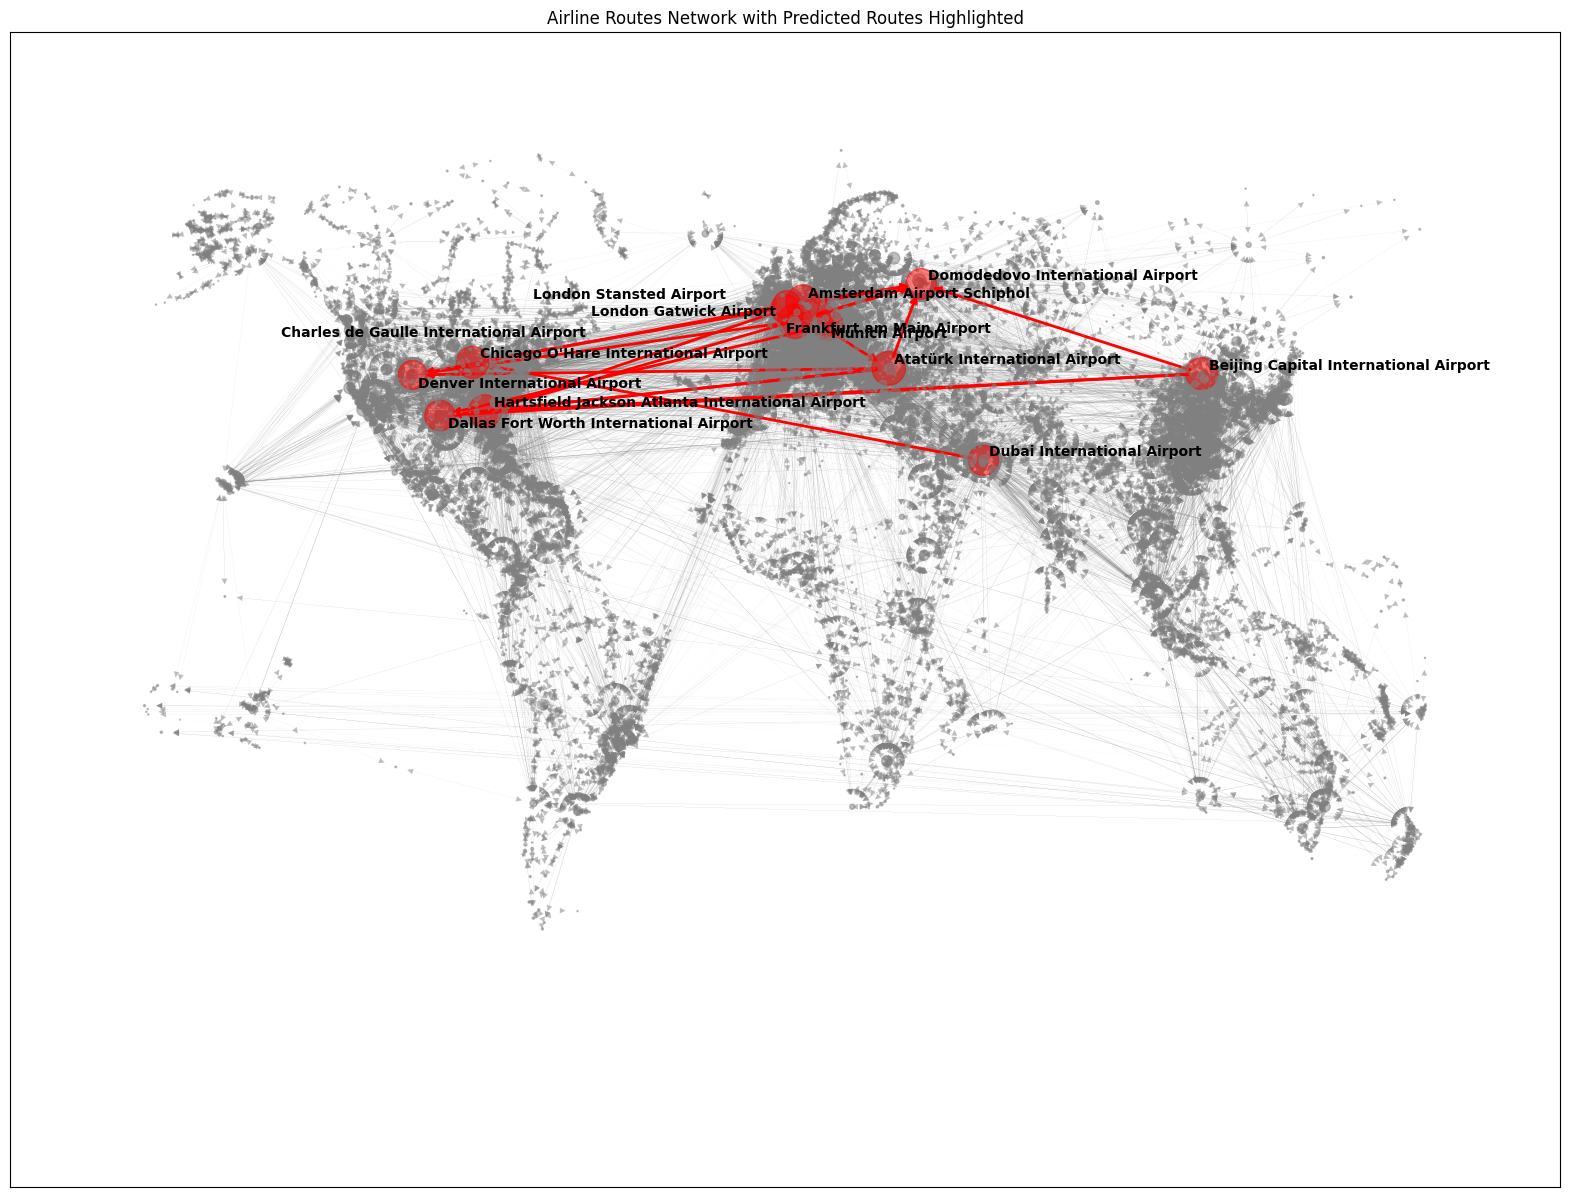

In [ ]:
# Visualizing predicted routes on the graph/map

# Get position of nodes
pos = {row['ID']: (row['Longitude'], row['Latitude']) for _, row in airports.iterrows()}

# Get edge weights for visualization
edge_weights = nx.get_edge_attributes(G_filtered, "weight")

# Normalize edge weights for better visualization
normalized_weights = {edge: 0.6 * (w / max(edge_weights.values())) for edge, w in edge_weights.items()}


# Generate the labels for the airports involved in the predicted routes
predicted_labels = {node: G_filtered.nodes[node]['name'] for edge in predicted_edges_pa for node in edge}

# Generate node sizes and colors for predicted and other nodes
predicted_nodes = {node for edge in predicted_edges_pa for node in edge}
predicted_node_sizes = [degree_centrality[node]*10000 if node in predicted_nodes else degree_centrality[node]*2500 for node in G_filtered.nodes]
predicted_node_colors = ['red' if node in predicted_nodes else 'gray' for node in G_filtered.nodes]



# Draw the graph
plt.figure(figsize=(20, 15))

# Draw other nodes
nx.draw_networkx_nodes(G_filtered, pos, node_size=predicted_node_sizes, node_color=predicted_node_colors, cmap=plt.cm.viridis, alpha=0.5)

# Draw other edges
nx.draw_networkx_edges(G_filtered, pos, edge_color='gray', width=[normalized_weights[edge] for edge in G_filtered.edges], alpha=0.5)

# Draw predicted edges with different color and thickness
nx.draw_networkx_edges(G_filtered, pos, edgelist=predicted_edges_pa, edge_color='red', width=2)

texts = []
# Draw labels for the airports involved in predicted routes
for node, label in predicted_labels.items():
    x, y = pos[node]
    texts.append(plt.text(x, y, label, fontsize=10, weight='bold'))

adjust_text(texts)

plt.title("Airline Routes Network with Predicted Routes Highlighted")
plt.show()
